# Filter study for Cryoscope

**Goal**: testing filter application similarly to what I am supposed to do with FIR

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from scipy import special
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.signal import lfilter

from qibocal.protocols.two_qubit_interaction.cryoscope import _fit, _plot, CryoscopeData, CryoscopeType 

FULL_WAVEFORM = np.concatenate([np.zeros(10), np.ones(50), np.zeros(10)])


[Qibo 0.2.12|INFO|2024-12-11 09:01:11]: Loading platform dummy
[Qibo 0.2.12|INFO|2024-12-11 09:01:11]: Loading platform dummy


**Loading data**

In [2]:
with open('savgol_data.pkl', 'rb') as file:
    data_phase = pickle.load(file)
    savgol_demod = data_phase["savgol_demod"]
    savgol_no_demod = data_phase["savgol_no_demod"]
    no_savgol_demod = data_phase["no_savgol_demod"]
    no_savgol_no_demod = data_phase["no_savgol_no_demod"]

with open('CryoscopeResults.pkl', 'rb') as file:
    data_results = pickle.load(file)
    result_svg_dem = data_results["savgol_demod"]
    result_svg_no_dem = data_results["savgol_no_demod"]
    result_no_svg_dem = data_results["no_savgol_demod"]
    result_no_svg_no_dem = data_results["no_savgol_no_demod"]

#### Reproduce rectangular impulse response

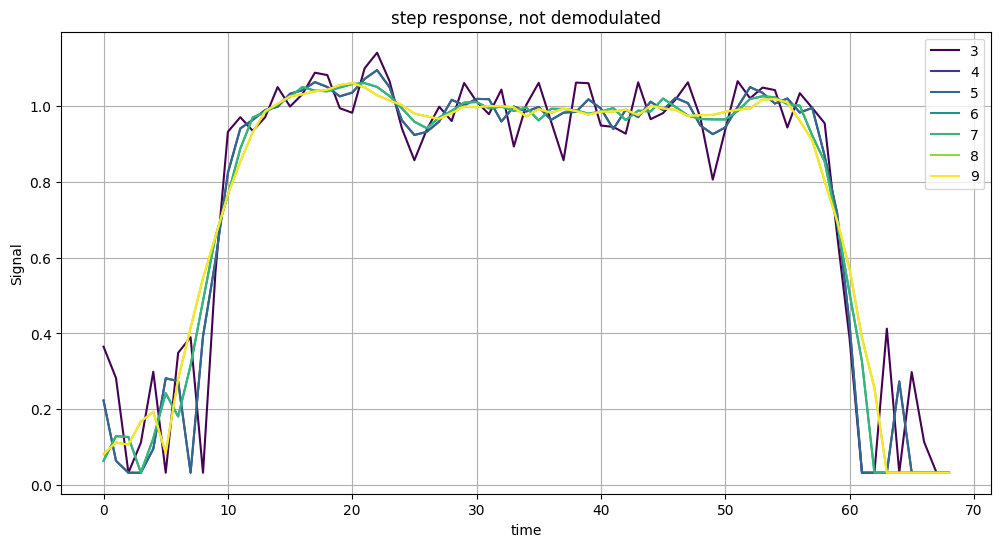

In [3]:
colors = plt.cm.viridis(np.linspace(0, 1, len(savgol_demod)))

plt.figure(figsize=(12, 6)) 

for i, res in enumerate(result_svg_no_dem):
    plt.plot(res.step_response["D1"], color = colors[i], label=f"{i+3}" )
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("step response, not demodulated")
plt.legend()
plt.grid()
plt.show()


### Definining filters on step function

In [4]:
def step(t):
    return np.where(t<10, 0, 1)

t = np.arange(0,50,1)

In [5]:
#Filters used in the papaer for simulation

def bias_1(t, g, tau):
    return g*(np.exp((-t)/tau))*step(t)

def bias_2(t, g, tau, A):
    return g*(1 + A*np.exp(-t/tau))*step(t)

def bias_3(t, g, tau, A):
    return g*(1 + A*np.exp(-t/tau))*step(t)

def skin_effect(t, g, alpha):
    return g*(1-special.erfc(alpha*np.sqrt(t)/21))*step(t)

def on_chip(t, g, tau, A):
    return g*(1 + A*np.exp(-t/tau))*step(t)

## Minimization on step

In [6]:
def model(params, t, data):
    g, tau, A = params
    return data/(g*(1 + A*np.exp(-(t-10)/tau)))  #exp(-(t-10)/tau)


def residuals(params, t, data):
    return model(params, t, data) - step(t)

In [7]:
initial_guess = [1, 1, 1]
t = np.arange(0,30,1)
step_response = result_svg_no_dem[4].step_response["D1"][0:30]
print(len(step_response))

30


In [8]:
result = least_squares(residuals, initial_guess, args=(t, step_response))
print(result)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-4.717e-26 -2.827e-23 ... -2.011e-02  1.537e-03]
           x: [ 1.008e+00  1.755e-01 -2.418e-01]
        cost: 0.018943915785561153
         jac: [[ 4.680e-26 -1.531e-23 -1.950e-25]
               [ 2.806e-23 -8.261e-21 -1.169e-22]
               ...
               [-9.724e-01  0.000e+00 -0.000e+00]
               [-9.939e-01  0.000e+00 -0.000e+00]]
        grad: [ 1.003e-09  8.490e-08 -3.189e-07]
  optimality: 3.189443486096384e-07
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 14
        njev: 11


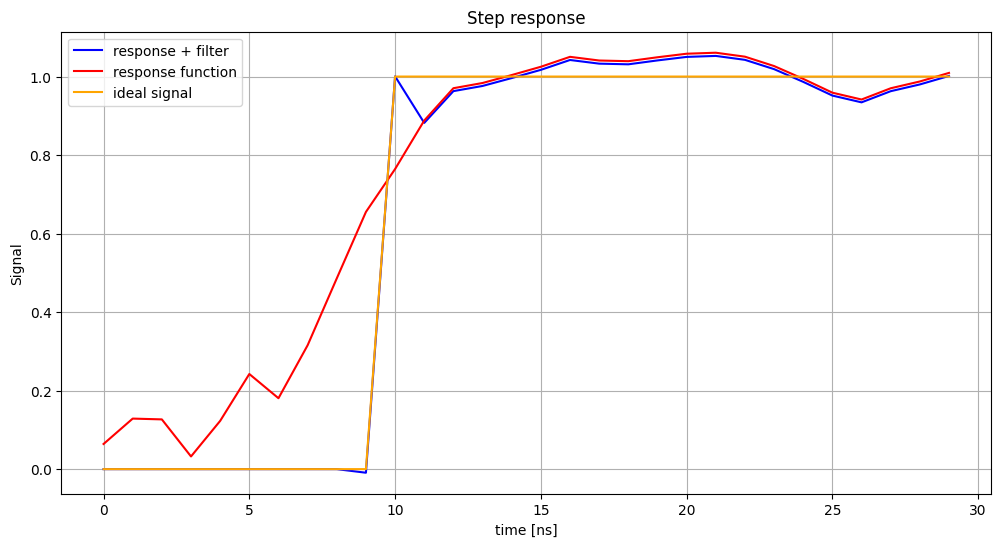

In [9]:
plt.figure(figsize=(12, 6)) 
plt.plot(t, model(result.x, t, step_response), color = "blue", label="response + filter")
plt.plot(step_response, color = "red", label="response function")
plt.plot(t, step(t), color = "orange", label="ideal signal" )
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

In [10]:
init_guess = [1,1,1]
results = []
responses = []

for i in range(5):
    result = least_squares(residuals, initial_guess, args=(t, step_response)) #calcolo LSO
    results.append(result) 
    step_response = model(result.x,t,step_response) #reference data update
    responses.append(step_response) #store data at each iteration

/tmp/ipykernel_13002/3813422741.py:3: RuntimeWarning: overflow encountered in exp
  return data/(g*(1 + A*np.exp(-(t-10)/tau)))  #exp(-(t-10)/tau)


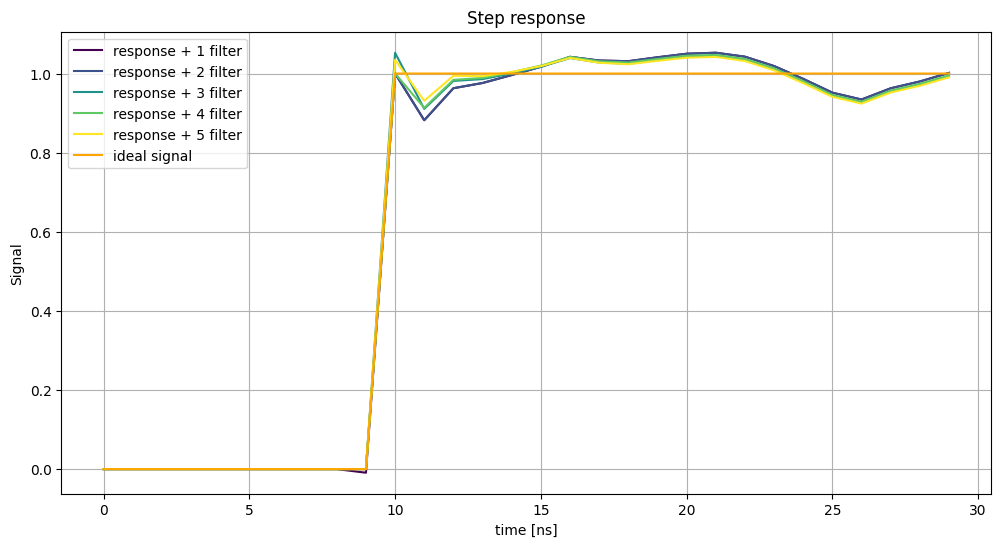

In [11]:
step_response = result_svg_no_dem[4].step_response["D1"][10:40]
colors = plt.cm.viridis(np.linspace(0, 1, len(responses)))

plt.figure(figsize=(12, 6))

for i, resp in enumerate(responses):
    plt.plot(t, resp, color=colors[i], label=f"response + {i+1} filter")
#plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

## Minimization on constant signal

**Risposta sollo sull'intervallo 10 - 40**

Provo ad applicare il modello (e ottimizzarlo) sulla risposta a partire dall'invio di un segnale non nullo.

NB: devo ridefinire modello e filtro perchè l'esponenziale non sia traslato, devo ridefinire anche il segnale ideal perchè in questo caso la step function è semplicemente un vettore oneslike

In [12]:
def step(t):
    return np.ones_like(t)

def model(params, t, data):
    g, tau, A = params
    return data/(g*(1 + A*np.exp(-t/tau)))  #exp(-t/tau)


def residuals(params, t, data):
    return model(params, t, data) - step(t)

In [13]:
initial_guess = [1, 1, 1]
t = np.arange(0, 30, 1)
step_response = result_svg_no_dem[4].step_response["D1"][10:40]
print(len(step_response))

30


In [14]:
result = least_squares(residuals, initial_guess, args=(t, step_response))
print(result)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 3.879e-03 -1.545e-02 ... -1.883e-02 -2.777e-02]
           x: [ 1.008e+00  1.184e+00 -2.444e-01]
        cost: 0.013525619800523426
         jac: [[-9.961e-01  0.000e+00 -1.329e+00]
               [-9.769e-01  8.244e-02 -4.727e-01]
               ...
               [-9.736e-01  0.000e+00 -0.000e+00]
               [-9.647e-01  0.000e+00 -0.000e+00]]
        grad: [-1.036e-09 -3.966e-07 -1.431e-07]
  optimality: 3.965798406411602e-07
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 9
        njev: 8


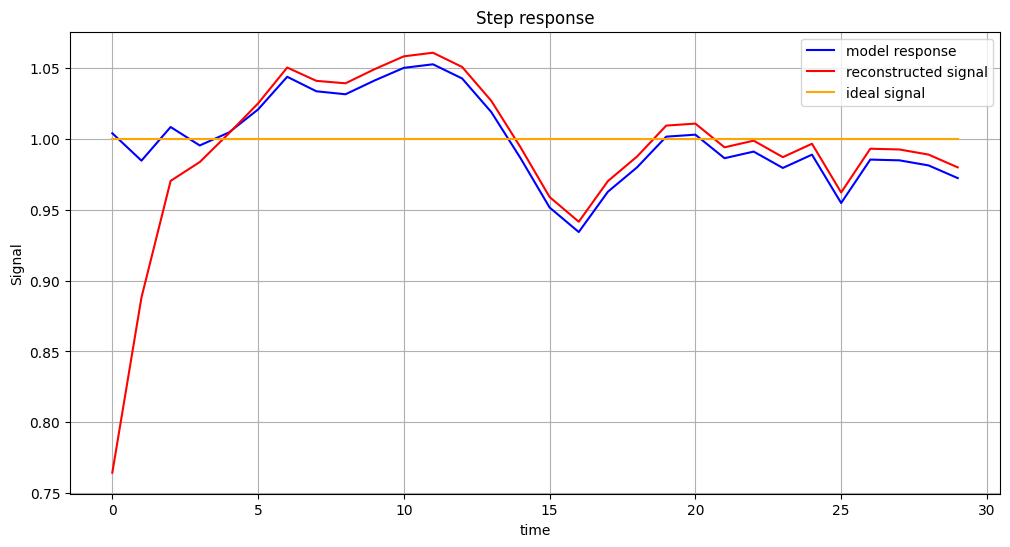

In [15]:
plt.figure(figsize=(12, 6)) 
plt.plot(t, model(result.x, t, step_response), color = "blue", label="model response")
plt.plot(step_response, color = "red", label="reconstructed signal")
plt.plot(t, step(t), color = "orange", label="ideal signal" )
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

Applicazione iterativa del filtro

In [16]:
init_guess = [1,1,1]
results = []
responses = []

for i in range(5):
    result = least_squares(residuals, initial_guess, args=(t, step_response)) #calcolo LSO
    results.append(result) 
    step_response = model(result.x,t,step_response) #reference data update
    responses.append(step_response) #store data at each iteration

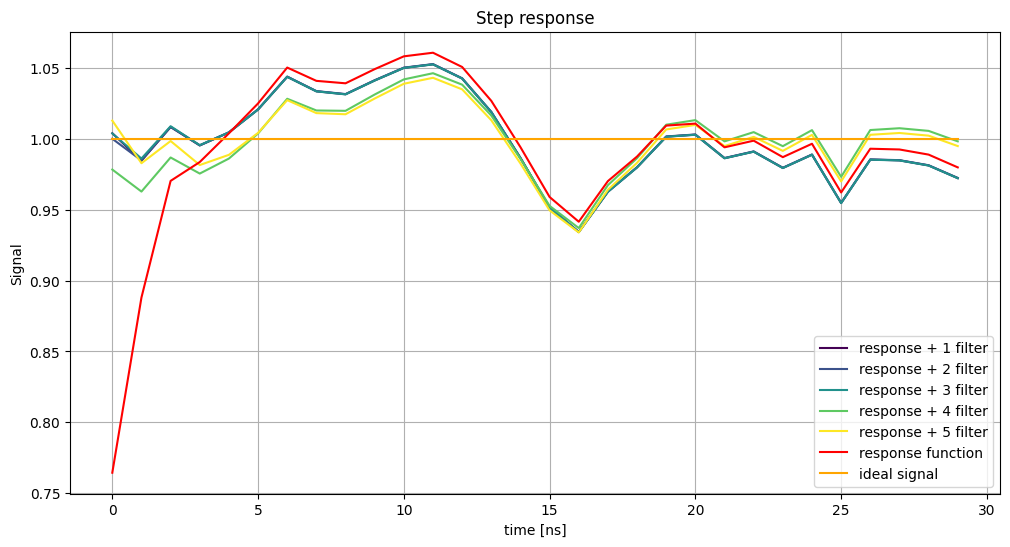

In [17]:
step_response = result_svg_no_dem[4].step_response["D1"][10:40]
colors = plt.cm.viridis(np.linspace(0, 1, len(responses)))

plt.figure(figsize=(12, 6))

for i, resp in enumerate(responses):
    plt.plot(t, resp, color=colors[i], label=f"response + {i+1} filter")
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

# FIR filters

In [18]:
import cma

def FIR_filter(x, b):
    """Applies the FIR filter to the input signal x using coefficients b."""
    # N = len(b)
    y = np.convolve(x, b, mode='full')[:len(x)]  
    # così sto semplicemente tagliando la convoluzione alla lunghezza del segnale di input
    # capire se c'è un modo più efficace per fare questo ed eventualmente come
    # hanno applicato questi FIR
    return y


def cost_function(bs, signal, t):
    y = FIR_filter(signal, bs)
    return np.sum((y - step(t)) ** 2)


signal = responses[-1]  # il segnale di partenza è quello a cui ho già applicato gli IIR
ideal_signal = step(t)
initial_guess = np.random.rand(30)
sigma = 0.25

result = cma.fmin(lambda bs: cost_function(bs, signal, t), initial_guess, sigma)

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 30 (seed=1008529, Wed Dec 11 09:01:30 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 6.679423942235672e+02 1.0e+00 2.40e-01  2e-01  2e-01 0:00.0
    2     28 2.669371986421867e+02 1.1e+00 2.37e-01  2e-01  2e-01 0:00.0
    3     42 1.261169775121250e+02 1.1e+00 2.40e-01  2e-01  2e-01 0:00.0


  100   1400 4.466225369341116e+00 2.7e+00 1.35e-01  1e-01  1e-01 0:00.4
  200   2800 3.961029812500479e-01 5.6e+00 5.06e-02  5e-02  5e-02 0:00.7
  300   4200 1.376541741685178e-02 1.1e+01 1.38e-02  1e-02  2e-02 0:01.0
  400   5600 1.349195670802327e-04 1.6e+01 2.29e-03  2e-03  2e-03 0:01.4
  500   7000 4.018261518044346e-07 2.1e+01 1.45e-04  1e-04  1e-04 0:01.7
  600   8400 3.928283761929219e-10 2.6e+01 4.39e-06  3e-06  4e-06 0:02.0
  700   9800 3.390734238355413e-13 3.0e+01 1.60e-07  9e-08  1e-07 0:02.4
  729  10206 2.690806450553975e-14 3.0e+01 5.00e-08  3e-08  4e-08 0:02.5
termination on tolfun=1e-11 (Wed Dec 11 09:01:35 2024)
final/bestever f-value = 2.179535e-14 2.179535e-14 after 10207/10207 evaluations
incumbent solution: [ 0.9873616   0.02931802 -0.01440423  0.01563867 -0.00583923 -0.01597704
 -0.02296696  0.00782523 ...]
std deviations: [2.60908209e-08 3.58429004e-08 3.42805287e-08 3.17542422e-08
 3.44915567e-08 3.56553031e-08 3.60398478e-08 3.86462633e-08 ...]


Mean Squared Error: 7.265116358624697e-16


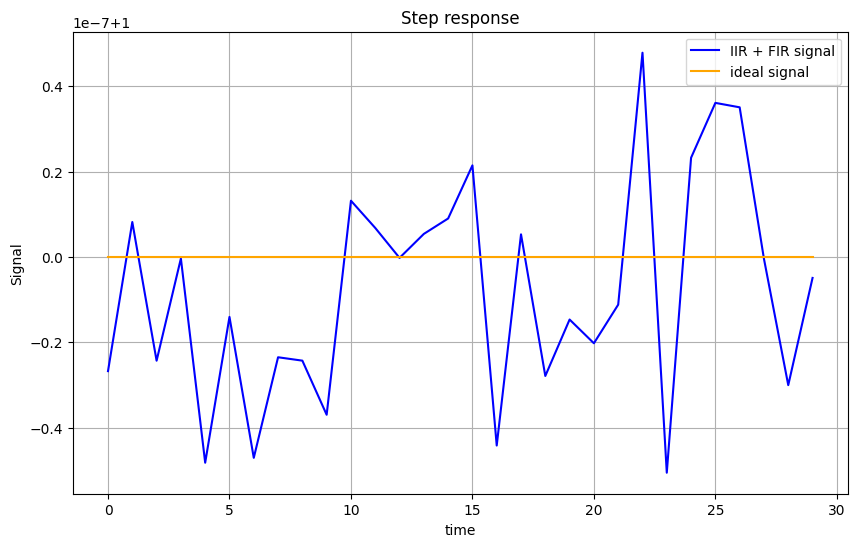

In [23]:
optimized_bs = result[0]
filtered_signal = FIR_filter(signal, optimized_bs)

mse = np.mean((filtered_signal - ideal_signal)**2)
print(f"Mean Squared Error: {mse}")

plt.figure(figsize=(10, 6))
plt.plot(filtered_signal, color="blue", label="IIR + FIR signal")
#plt.plot(signal, color="red", label="IIR signal")
plt.plot(t, step(t), color="orange", label="ideal signal")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()